In [9]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
import global_values
from groups import *
from merge_groups_best_candidate import *
from puzzle import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_values.MODEL = SiameseCNN()
global_values.MODEL.load_state_dict(torch.load("siamese_weights_imbalanced_lr-6.pth", map_location=device))
global_values.MODEL.to(device)
global_values.MODEL.eval()
global_values.DEVICE = device
NN_SCORING = True
ROTATING_PIECES = True



def clasic_score_one_image_passing(side_comparison, th = global_values.IMAGE_TH):
    if side_comparison.score < th:
        return True
    return False

def prudent_x_buddy_one_image_passing(side_comparison, th = global_values.PRUDENT_X_BUDDY_TH_IMAGE):
    if side_comparison.prudent_score * side_comparison.buddy_score < th:
        return True
    return False

## mai indicat pt astea mai mari
def safe_clasic_score_one_image_passing(side_comparison, th = 0.015):
    if side_comparison.score < th:
        return True
    return False

def mean_clasic_score(mean, th = global_values.GROUP_TH):
    if mean < th:
        return True
    return False

def no_mean_score(mean, th = 0):
    return True


In [10]:
image = "0477.png"
image_path = os.path.join("all_images",image)

output_folder = "fragments"

global_values.COL_NR = 2
global_values.ROW_NR = 2
solution_path = f"solution/valid_comparisons_{global_values.COL_NR}_{global_values.ROW_NR}{image}.txt"

fragments, tile_h, tile_w = divide_image(image_path, output_folder,solution_path, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)
print("rotation dictionary")
fragment_rotation_dictionary = create_fragment_rotation_dictionary(fragments, tile_h, tile_w)
fragment_rotation_dictionary = create_fragment_rotation_tensor_dictionary(fragment_rotation_dictionary)

print("create side comps")
sides_pairs = create_sides_pairs_for_nn(fragments)
sides_comparisons = create_sides_comparisons_with_score_nn(global_values.MODEL, device,  fragment_rotation_dictionary, sides_pairs)
sides_comparisons = calculate_buddy_score(fragments,sides_comparisons)
print("sort")
sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(c.side2, c.side1, c.score)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp





Rotations by fragment: 0)0.0, 1)0.0, 2)0.0, 3)0.0
rotation dictionary


100%|██████████| 4/4 [00:00<00:00, 52428.80it/s]


create side comps


100%|██████████| 24/24 [00:00<00:00, 267011.40it/s]

sort


In [11]:
global_values.IMAGE_TH = 0.01
global_values.GROUP_TH = 0.0025

In [17]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3]


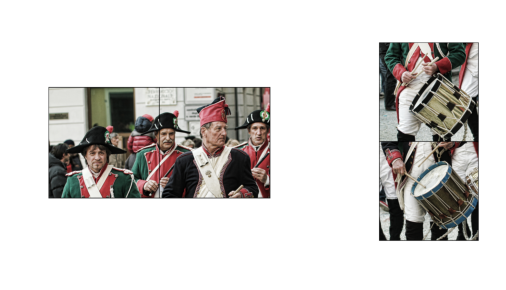

In [18]:
groups, fragments, fragment_idx_to_group_idx = merge_where_obvious(clasic_score_one_image_passing, no_mean_score, 0.001, 0.015, sorted_sides_comparisons, fragment_idx_to_group_idx, fragments, groups)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)


No valid merge candidates found.


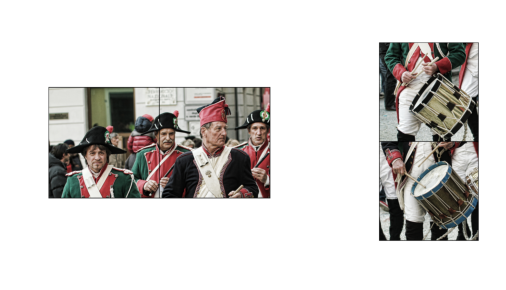

In [14]:
groups, fragments, fragment_idx_to_group_idx = solve_groups_safe(groups, fragments, fragment_idx_to_group_idx)
show_all_groups(groups, fragments, fragment_idx_to_group_idx, 0)



In [15]:
gt_comparisons = read_valid_comparisons(solution_path)



comparisons = []

for g in groups:
    n = len(g.grid)
    m = len(g.grid[0])

    for i in range(n):
        for j in range(m):
            fr1_idx = g.grid[i][j]
            if fr1_idx is not None:
                if j + 1 < m:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 1)
                    fr2_idx = g.grid[i][j + 1]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation,3)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

                if i + 1 < n:
                    side1_idx = find_side_idx_of_orientation(fragments[fr1_idx].rotation, 2)
                    fr2_idx = g.grid[i + 1][j]
                    if fr2_idx is not None:
                        side2_idx = find_side_idx_of_orientation(fragments[fr2_idx].rotation, 0)
                        comparisons.append((fr1_idx, fr2_idx, side1_idx, side2_idx))

correct = 0
nr_of_comp = int((2 * 4 + 3 * ((global_values.COL_NR - 2) * 2 + (global_values.ROW_NR - 2)* 2) + 4 * ((global_values.COL_NR -2) * (global_values.COL_NR-2)))/2)
for s_comp in comparisons:
    for gt_comp in gt_comparisons:
        if s_comp == gt_comp:
            correct+=1
        if s_comp[0] == gt_comp[1] and s_comp[1] == gt_comp[0] and s_comp[2] == gt_comp[3] and s_comp[3] == gt_comp[2]:
            correct+=1

accuracy = (correct/nr_of_comp) * 100
print(f"Accuracy of algorithm: {accuracy}%")

Accuracy of algorithm: 25.0%


In [16]:
# introducere problema imagini input output

# care e algolritmul (greedy)
# functia de potrivire
# siameza

# cum merge pe low level, simaza pe diferiti nr pixeli
# timp

# 9 iunie licenta
